In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv
/kaggle/input/store-sales-submissions/submission_39331.csv
/kaggle/input/store-sales-submissions/submission_39359.csv
/kaggle/input/store-sales-submissions/submission_39274.csv
/kaggle/input/store-sales-submissions/submission_39369.csv
/kaggle/input/store-sales-submissions/submission_39347.csv
/kaggle/input/store-sales-submissions/submission_39263.csv
/kaggle/input/store-sales-submissions/submission_39281.csv
/kaggle/input/store-sales-submissions/submission_38415.csv
/kaggle/input/store-sales-submissions/submission_39261.csv
/kaggle/input/store-sa

# 1.Model Building and Data Analysis
# 1.Model Oluşturma ve Veri Analizi

#### İmport Necessary Library
#### Gerekli Kütüphaneleri Yükle

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_df = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [4]:
train_df.shape

(3000888, 6)

In [5]:
train_df['date'] = pd.to_datetime(train_df['date'])

#### Veriyi daha iyi anlamak için çeşitli görselleştirmeler yap
#### Make various visualizations to better understand the data

<AxesSubplot:xlabel='sales', ylabel='Count'>

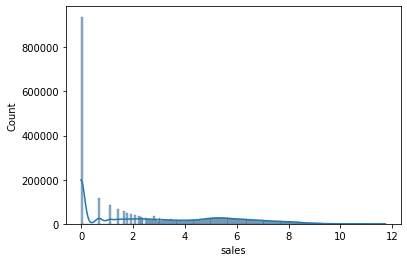

In [6]:
sns.histplot(np.log1p(train_df['sales']), kde=True)

#### by monthly sales according to store_nbr
#### store_nbr'ye göre aylık satışla

Text(0.5, 1.0, 'Depo numarasına göre aylık satışlar')

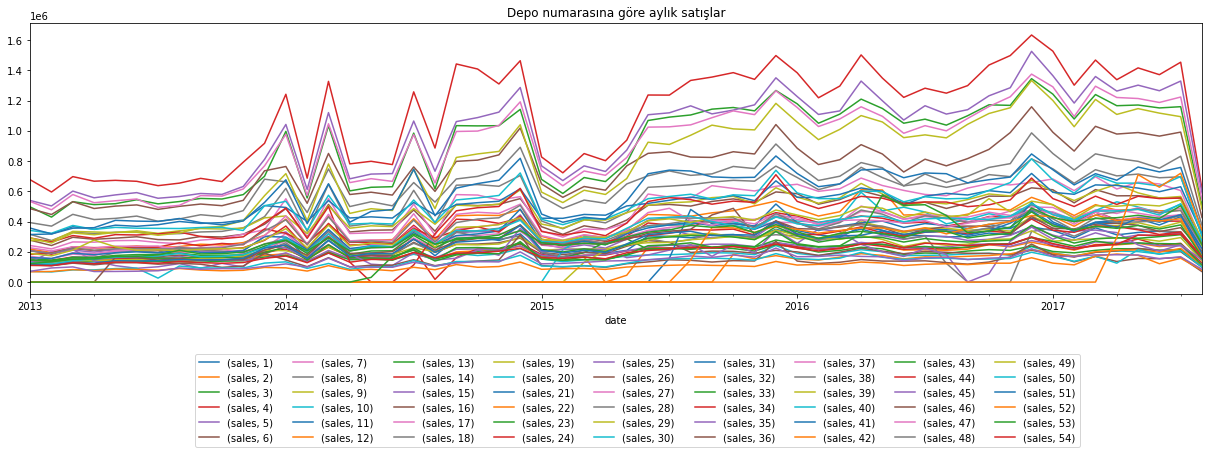

In [7]:
# Her bir ay için toplam satışları depo numarasına göre grupla
store_nbr_sales_per_month = train_df.groupby(['date', 'store_nbr']).agg({'sales': 'sum'}).unstack().resample('1M').sum()

# Satışları çiz
store_nbr_sales_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(0.9, -0.2), ncol=9)
plt.title("Depo numarasına göre aylık satışlar")


#### Monthly sales by family
#### Aileye göre aylık satışlar

Text(0.5, 1.0, 'Ürün ailesine göre aylık satışlar')

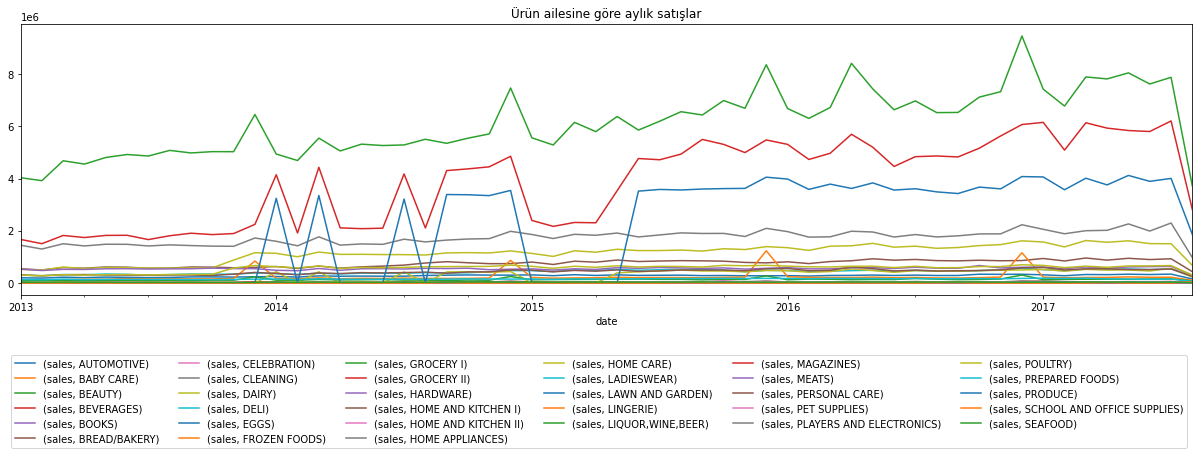

In [8]:
# Her bir ay için toplam satışları ürün ailesine göre grupla
family_sales_per_month = train_df.groupby(['date', 'family']).agg({'sales': 'sum'}).unstack().resample('1M').sum()

# Satışları çiz
family_sales_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(1, -.2), ncol=6)
plt.title("Ürün ailesine göre aylık satışlar")


<AxesSubplot:xlabel='onpromotion', ylabel='Count'>

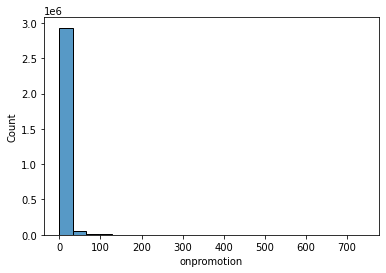

In [9]:
sns.histplot(data=train_df, x='onpromotion')

In [10]:
# train_df'nin satış sütununda log dönüşümü uygula
train_df['sales'] = np.log1p(train_df['sales'])

# stores.csv dosyasını oku ve ilk birkaç satırını göster
stores_df = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
stores_df.head()


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
stores_df.shape

(54, 5)

In [12]:
transactions_df = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [13]:
transactions_df['date'] = pd.to_datetime(transactions_df['date'])
transactions_df.shape


(83488, 3)

#### Monthly transactions by store_nbr
#### Store_nbrye göre aylık işlemler

Text(0.5, 1.0, 'Depo numarasına göre aylık işlemler')

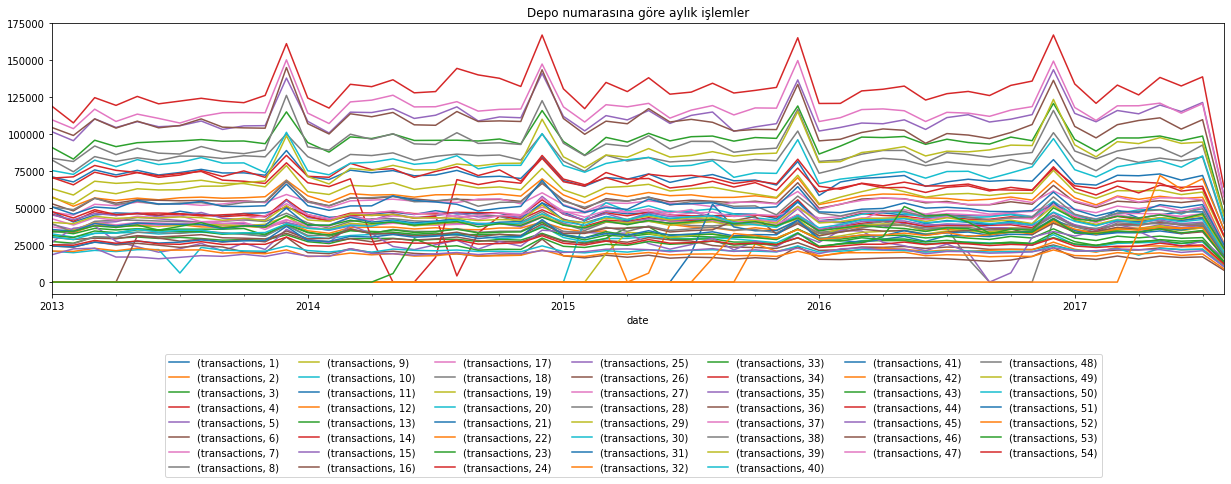

In [14]:
# Her bir ay için toplam işlem sayısını depo numarasına göre grupla
store_nbr_transactions_per_month = transactions_df.groupby(['date', 'store_nbr']).agg({'transactions': 'sum'}).unstack().resample('1M').sum()

# İşlem sayılarını çiz
store_nbr_transactions_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(0.9,-0.2), ncol=7)
plt.title('Depo numarasına göre aylık işlemler')

In [15]:
test_df = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [16]:
test_id = test_df['id']
test_df['date'] = pd.to_datetime(test_df['date'])

In [17]:
test_df.shape

(28512, 5)

In [18]:
holidays_df = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [19]:
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

In [20]:
holidays_df.shape

(350, 6)

In [21]:
oil_df = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [22]:
# 'dcoilwtico' sütunundaki eksik değerleri arkadan doldur
oil_df['dcoilwtico'].fillna(method='backfill', inplace=True)

# 'date' sütununu datetime tipine dönüştür
oil_df['date'] = pd.to_datetime(oil_df['date'])

# oil_df'nin boyutunu yazdır
oil_df.shape

(1218, 2)

Text(0.5, 1.0, 'Petrol fiyatı')

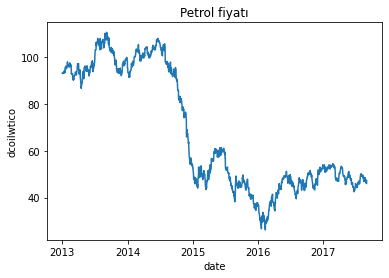

In [23]:
sns.lineplot(data=oil_df, x='date', y='dcoilwtico')
plt.title('Petrol fiyatı')

#### Fonksiyon yardımıyla hızlı veri okuma 
#### Fast data reading with the help of the function

In [24]:
def lag_features(df, lags):
    for lag in lags:
        # 'store_nbr' ve 'family' sütunlarına göre 'sales' sütununun önceki değerlerini alarak 'sales_t-lag' sütununu oluştur
        df[f"sales_t-{lag}"] = df.groupby(["store_nbr", "family"])["sales"].transform(
            lambda x: x.shift(lag))
    return df


In [25]:
def fill_na(df):
    # 'holiday_type' sütunundaki eksik değerleri 'Common' ile doldur
    df['holiday_type'] = df['holiday_type'].fillna('Common')
    # 'locale' sütunundaki eksik değerleri 'Common' ile doldur
    df['locale'] = df['locale'].fillna('Common')
    # 'description' sütunundaki eksik değerleri 'Unknown' ile doldur
    df['description'] = df['description'].fillna('Unknown')
    # 'transferred' sütunundaki eksik değerleri False ile doldur
    df['transferred'] = df['transferred'].fillna(False)
    # 'dcoilwtico' sütunundaki eksik değerleri arkadan doldur
    df['dcoilwtico'] = df['dcoilwtico'].fillna(method='backfill')
    return df


In [26]:
def merge_data(df):
    df = df \
        .merge(stores_df, left_on="store_nbr", right_on="store_nbr", how="left") \
        .rename(columns={"type": "store_type"}) \
        .merge(transactions_df, left_on=["date", "store_nbr"], right_on=["date", "store_nbr"], how="left") \
        .merge(holidays_df, left_on="date", right_on="date", how="left") \
        .drop_duplicates(subset="id") \
        .rename(columns={"type": "holiday_type"}) \
        .merge(oil_df, left_on="date", right_on="date", how="left") 
    return df


In [27]:
def create_date_features(df):
    df['month'] = df['date'].dt.month
    df['day_of_month'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_week'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    return df


In [28]:
def random_noise(dataframe):
    return np.random.normal(scale=2.0, size=(len(dataframe),))

In [29]:
def roll_mean_features(dataframe, windows):
    def add_noise(x):
        return x + np.random.normal(size=len(x))

    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store_nbr", "family"])['sales']. \
                                                          transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=7, win_type="triang").mean())
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store_nbr", "family"])['sales_roll_mean_' + str(window)].transform(add_noise)
    return dataframe


In [30]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            feature_name = 'sales_ewm_alpha_' + str(alpha).replace(".", "") + '_lag_' + str(lag)
            dataframe[feature_name] = dataframe.groupby(["store_nbr", "family"])['sales'].\
                transform(lambda x: x.shift(lag).ewm(alpha=alpha, min_periods=1).mean())
    return dataframe


In [31]:
col = [
    'date',
    'store_nbr', 
    'family', 
    'sales', 
    'onpromotion', 
    'cluster', 
    'holiday_type', 
    'locale', 
    'description', 
    'transferred',
    'dcoilwtico'
]

In [32]:
all_df = pd.concat([train_df, test_df], axis=0)
all_df = merge_data(all_df)
all_df = fill_na(all_df)
all_df = create_date_features(all_df)
all_df = lag_features(all_df, lags=[*range(1, 16), 16, 17, 18, 19, 20, 21, 22, 30, 31, 90, 180, 364])
all_df = roll_mean_features(all_df, [16, 17, 18, 30])
all_df = all_df[col]


In [33]:
alphas = [0.95, 0.9, 0.8, 0.5]
lags =[1, 7,30]
all_df = ewm_features(all_df, alphas, lags)

In [34]:
all_df['store_nbr'] = all_df['store_nbr'].astype('category')
all_df['family'] = all_df['family'].astype('category')
all_df['store_nbr'] = all_df['store_nbr'].astype('category')
all_df['cluster'] = all_df['cluster'].astype('category')
all_df['family'] = all_df['family'].astype('category')
all_df['holiday_type'] = all_df['holiday_type'].astype('category')
all_df['locale'] = all_df['locale'].astype('category')
all_df['description'] = all_df['description'].astype('category')

In [35]:
all_df

,date,store_nbr,family,sales,onpromotion,cluster,holiday_type,locale,description,transferred,...,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,6,Common,Common,Unknown,False,...,6.338358,6.045064,6.045064,6.329319,6.012643,6.012643,6.311631,5.957384,5.957384,6.244803
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,6,Common,Common,Unknown,False,...,3.953042,5.016271,5.016271,3.969407,4.984993,4.984993,4.014010,4.894600,4.894600,4.210488
3029397,2017-08-31,9,PRODUCE,NaN,1,6,Common,Common,Unknown,False,...,7.788738,7.735485,7.735485,7.765895,7.682595,7.682595,7.722496,7.532320,7.532320,7.590557
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,6,Common,Common,Unknown,False,...,5.253514,4.845138,4.845138,5.186784,4.885929,4.885929,5.043656,4.982981,4.982981,4.438414


In [36]:
all_df = all_df[all_df['date'] > '2013-12-31']
X = all_df[all_df['date'] <= '2017-08-15'].drop('date', axis=1)
X_test = all_df[all_df['date'] > '2017-08-15'].drop('date', axis=1)


In [37]:
corr = X.corr()
corr['sales'].sort_values(ascending=False)

sales                         1.000000
sales_ewm_alpha_05_lag_1      0.973090
sales_ewm_alpha_08_lag_1      0.968657
sales_ewm_alpha_05_lag_7      0.966604
sales_ewm_alpha_09_lag_1      0.966508
sales_ewm_alpha_095_lag_1     0.965262
sales_ewm_alpha_08_lag_7      0.964625
sales_ewm_alpha_09_lag_7      0.963186
sales_ewm_alpha_095_lag_7     0.962281
sales_ewm_alpha_05_lag_30     0.923159
sales_ewm_alpha_08_lag_30     0.916762
sales_ewm_alpha_09_lag_30     0.914276
sales_ewm_alpha_095_lag_30    0.912902
onpromotion                   0.358192
transferred                  -0.006167
dcoilwtico                   -0.116986
Name: sales, dtype: float64

In [38]:
Y = X['sales']
X = X.drop(['sales'], axis=1)
X_test = X_test.drop(['sales'], axis=1)


In [39]:
X.shape, Y.shape, X_test.shape

((2352240, 21), (2352240,), (28512, 21))

In [40]:
#!pip install lightgbm
#!pip install catboost

# Model Building And Data Analysis 
# Model Oluşturma ve Veri Analizi

## İmport Necessary Library
## Gerekli Kütüphaneleri Yükle

In [41]:
import numpy as np
import pandas as pd
from random import random
import os

from sklearn.metrics import mean_squared_log_error as msle
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm

from matplotlib import pyplot as plt, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from tqdm import tqdm

from pandas_profiling import ProfileReport

import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

In [42]:
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv', parse_dates = ['date'], infer_datetime_format = True, index_col=['id'])

In [43]:
test['date'] = test.date.dt.to_period('D')

In [44]:
df_pred = test.copy()

#### Return files quickly with function
#### Fonksiyon ile dosyaları hızlı şekilde dön

In [45]:
for dirname, _, filenames in os.walk('/kaggle/input/store-sales-submissions'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        df_pred['sub_'+filename.split('_')[1].split('.')[0]] = pd.read_csv(os.path.join(dirname, filename), index_col=['id']).sales


/kaggle/input/store-sales-submissions/submission_39331.csv
/kaggle/input/store-sales-submissions/submission_39359.csv
/kaggle/input/store-sales-submissions/submission_39274.csv
/kaggle/input/store-sales-submissions/submission_39369.csv
/kaggle/input/store-sales-submissions/submission_39347.csv
/kaggle/input/store-sales-submissions/submission_39263.csv
/kaggle/input/store-sales-submissions/submission_39281.csv
/kaggle/input/store-sales-submissions/submission_38415.csv
/kaggle/input/store-sales-submissions/submission_39261.csv
/kaggle/input/store-sales-submissions/submission_39262.csv
/kaggle/input/store-sales-submissions/submission_38558.csv
/kaggle/input/store-sales-submissions/submission_39266.csv


In [46]:
df_pred.head()

,date,store_nbr,family,onpromotion,sub_39331,sub_39359,sub_39274,sub_39369,sub_39347,sub_39263,sub_39281,sub_38415,sub_39261,sub_39262,sub_38558,sub_39266
id,,,,,,,,,,,,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,3.657460,3.575363,3.680601,3.602805,3.602805,3.602805,3.572214,3.453666,3.602805,3.602805,3.128176,3.602805
3000889,2017-08-16,1,BABY CARE,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3000890,2017-08-16,1,BEAUTY,2,5.143072,4.705614,4.481895,4.550604,4.550604,4.550604,4.667599,4.695971,4.550604,4.550604,4.239227,4.550604
3000891,2017-08-16,1,BEVERAGES,20,2289.104965,2254.839529,2256.487200,2256.487200,2256.487200,2256.487200,2256.487200,2301.266606,2256.487200,2256.487200,2359.855324,2256.487205
3000892,2017-08-16,1,BOOKS,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Pandas Profil ile kolayca verileri incele 
#### Examine data easily with Pandas Profile

In [47]:
test_profile = ProfileReport(test, title="test_profile")
test_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv', parse_dates = ['date'], infer_datetime_format = True, index_col=['id'])
test['date'] = test.date.dt.to_period('D')

df_pred = test.copy()

In [49]:
for dirname, _, filenames in os.walk('/kaggle/input/store-sales-submissions'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        df_pred['sub_'+filename.split('_')[1].split('.')[0]] = pd.read_csv(os.path.join(dirname, filename), index_col=['id']).sales

df_pred.head()

/kaggle/input/store-sales-submissions/submission_39331.csv
/kaggle/input/store-sales-submissions/submission_39359.csv
/kaggle/input/store-sales-submissions/submission_39274.csv
/kaggle/input/store-sales-submissions/submission_39369.csv
/kaggle/input/store-sales-submissions/submission_39347.csv
/kaggle/input/store-sales-submissions/submission_39263.csv
/kaggle/input/store-sales-submissions/submission_39281.csv
/kaggle/input/store-sales-submissions/submission_38415.csv
/kaggle/input/store-sales-submissions/submission_39261.csv
/kaggle/input/store-sales-submissions/submission_39262.csv
/kaggle/input/store-sales-submissions/submission_38558.csv
/kaggle/input/store-sales-submissions/submission_39266.csv


,date,store_nbr,family,onpromotion,sub_39331,sub_39359,sub_39274,sub_39369,sub_39347,sub_39263,sub_39281,sub_38415,sub_39261,sub_39262,sub_38558,sub_39266
id,,,,,,,,,,,,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,3.657460,3.575363,3.680601,3.602805,3.602805,3.602805,3.572214,3.453666,3.602805,3.602805,3.128176,3.602805
3000889,2017-08-16,1,BABY CARE,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3000890,2017-08-16,1,BEAUTY,2,5.143072,4.705614,4.481895,4.550604,4.550604,4.550604,4.667599,4.695971,4.550604,4.550604,4.239227,4.550604
3000891,2017-08-16,1,BEVERAGES,20,2289.104965,2254.839529,2256.487200,2256.487200,2256.487200,2256.487200,2256.487200,2301.266606,2256.487200,2256.487200,2359.855324,2256.487205
3000892,2017-08-16,1,BOOKS,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### all submissions are highly correlated
#### tüm gönderimler yüksek oranda ilişkilidir

<AxesSubplot:>

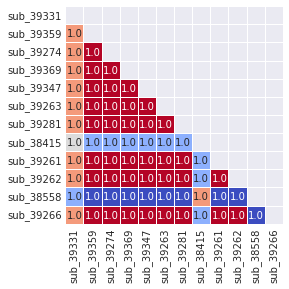

In [50]:
res = df_pred.drop(['store_nbr','onpromotion'], axis=1).groupby('family').mean()
res_corr = res.corr(method="spearman")
sns.heatmap(res_corr, annot=True, fmt='.1f', cmap='coolwarm', square=True, mask=np.triu(res_corr), linewidths=1, cbar=False)

#### Upgini only notebooks
#### Sadece Upgini not defterleri

In [51]:
pred_cols = ['sub_39331','sub_39359','sub_39274','sub_39369','sub_39347','sub_39263','sub_39281','sub_39261','sub_39262','sub_39266']

In [52]:
def func(dt):
    pred_res = pd.Series()
    for col in pred_cols:
        pred_res[col] = np.sqrt(np.sqrt(msle(dt[col], dt['sub_38558'])))
    return pred_res

####  "min" - is the column name with the predicted values closest to the best Darts "38558" submission
####  "min" - en iyi Dart "38558" gönderimine en yakın tahmin edilen değerlere sahip sütun adıdır

In [53]:
res = df_pred.groupby('family').apply(func)
res['min'] = res.idxmin(axis=1)
res

,sub_39331,sub_39359,sub_39274,sub_39369,sub_39347,sub_39263,sub_39281,sub_39261,sub_39262,sub_39266,min
family,,,,,,,,,,,
AUTOMOTIVE,0.374518,0.365258,0.364328,0.366008,0.366008,0.366008,0.364750,0.366008,0.366008,0.366010,sub_39274
BABY CARE,0.339326,0.328387,0.327605,0.327236,0.327236,0.327236,0.328600,0.327236,0.327236,0.327236,sub_39369
BEAUTY,0.476809,0.503078,0.502813,0.505084,0.505084,0.505084,0.503247,0.505084,0.505084,0.505084,sub_39331
BEVERAGES,0.315451,0.294803,0.295091,0.295091,0.295091,0.295091,0.295091,0.295091,0.295091,0.295087,sub_39359
BOOKS,0.212598,0.220923,0.221485,0.215813,0.212895,0.221291,0.221291,0.221485,0.221485,0.221485,sub_39331
BREAD/BAKERY,0.245458,0.255558,0.255917,0.255917,0.255917,0.255917,0.255917,0.255917,0.255917,0.255917,sub_39331
CELEBRATION,0.420220,0.408199,0.407565,0.408939,0.408939,0.408939,0.407741,0.408939,0.408939,0.408940,sub_39274
CLEANING,0.400930,0.380050,0.380682,0.387082,0.387082,0.387082,0.380431,0.386797,0.387082,0.386797,sub_39359
DAIRY,0.255023,0.271100,0.271701,0.271701,0.271701,0.271701,0.271701,0.271701,0.271701,0.271695,sub_39331


In [54]:
res['min'].value_counts()

sub_39331    13
sub_39359    10
sub_39274     4
sub_39266     4
sub_39369     2
Name: min, dtype: int64

<AxesSubplot:xlabel='date'>

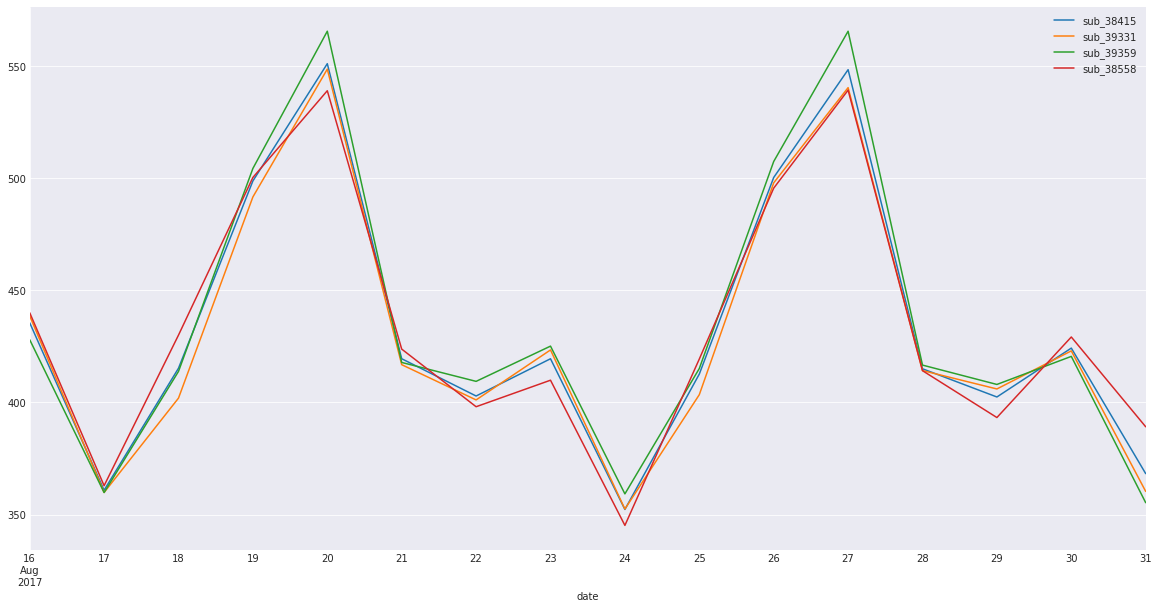

In [55]:
res = df_pred.groupby('date')[['sub_38415','sub_39331','sub_39359','sub_38558']].mean()
res.plot(figsize=(20,10))

#### stack the closest 3 submissions ['sub_39331','sub_39359','sub_38558'] - has the best score!
#### en yakın 3 gönderimi bir araya getirin ['sub_39331','sub_39359','sub_38558'] - en iyi skora sahip!

In [56]:
sub = pd.DataFrame(df_pred[['sub_39331','sub_39359','sub_38558']].mean(axis=1), columns=['sales']).reset_index()
sub.to_csv('submission_38558.csv', index = False)

#### en yakın 3 gönderimi yığın ['sub_38415','sub_39331','sub_39359'] - diğer 2 yakın çözümle önceki en iyi skor
#### stack the closest 3 submissions ['sub_38415','sub_39331','sub_39359'] - the previous best score with 2 other closest solutions

In [57]:
sub = pd.DataFrame(df_pred[['sub_38415','sub_39331','sub_39359']].mean(axis=1), columns=['sales']).reset_index()
sub.to_csv('submission_38415.csv', index = False)

#### en iyi 2 gönderimi istifleyin 
#### stack the 2 best submissions


In [58]:
sub = pd.DataFrame(df_pred[['sub_38415','sub_38558']].mean(axis=1), columns=['sales']).reset_index()
sub.to_csv('submission.csv', index = False)

In [59]:
sub_cols = pred_cols + ['sub_38558']

sub = pd.DataFrame(df_pred[sub_cols].mean(axis=1), columns=['sales']).reset_index()
sub.to_csv('submission_mean.csv', index = False)

#### mevcut tüm gönderimleri istifleyin
#### stack all existing submissions 


In [60]:
sub = pd.DataFrame(df_pred[pred_cols].mean(axis=1), columns=['sales']).reset_index()
sub.to_csv('submission2_pred.csv', index = False)